In [1]:
#调用torch库
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
#调用numpy库
import numpy as np
#调用matplotlib库
import matplotlib.pyplot as plt
#调用random库
import random

调用MNIST数据集

In [2]:
train_dataset = torchvision.datasets.MNIST(root="../Datasets/MNIST", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="../Datasets/MNIST", train=False, transform=transforms.ToTensor())

In [3]:
num_workers = 16
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

手动实现的前馈神经网络模型（解决多分类问题）

In [4]:
#使用课上给出的优化函数进行参数的学习优化
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size


# 损失函数使用手动实现的交叉熵损失函数
# y_hat为模型的预测值，而y为真实标签
def Loss(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [51]:
class Feedforward_multiclass:
    def __init__(self, image_size, class_num, opt, device, hidden=100):
        self.w_in = torch.tensor(np.random.normal(0, 0.01, (image_size * image_size, hidden)), dtype=torch.float32).to(device)
        self.b_in = torch.zeros(hidden, dtype=torch.float32).to(device)
        self.w_in.requires_grad_(requires_grad=True)
        self.b_in.requires_grad_(requires_grad=True) 

        self.w_out = torch.tensor(np.random.normal(0, 0.01, (hidden, class_num)), dtype=torch.float32).to(device)
        self.b_out = torch.zeros(class_num, dtype=torch.float32).to(device)
        self.w_out.requires_grad_(requires_grad=True)
        self.b_out.requires_grad_(requires_grad=True) 

        self.opt = opt

    def relu(self, x):
        x[x < 0.] = 0.
        return x 

    def softmax(self, x):
        x_exp = torch.exp(x)
        partition = x_exp.sum(1, keepdim=True)
        return x_exp / partition


    def forward(self, x):
        x = torch.matmul(x, self.w_in) + self.b_in
        x = self.relu(x)
        x = torch.matmul(x, self.w_out) + self.b_out
        return self.softmax(x)

    def learn(self, lr, bs):
        self.opt([self.w_in, self.b_in, self.w_out, self.b_out], lr, bs)

    def reset_grad(self):
        self.w_in.grad.data.zero_()
        self.b_in.grad.data.zero_()
        self.w_out.grad.data.zero_()
        self.b_out.grad.data.zero_()

In [6]:
# 计算预测的准确度
def accuracy(y_hat, y):  #@save
    y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [43]:
# 超参数设置
epoch_num = 20
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'
opt = sgd
loss = Loss
net = Feedforward_multiclass(image_size, class_num, sgd, device)
train_loss_list = []
test_loss_list = []
test_acc_list = []

In [8]:
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        # pre-proccess
        train_x = train_x.squeeze(1)
        train_x = train_x.flatten(1, 2)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        l.backward()
        net.learn(lr, batch_size)
        net.reset_grad()
        train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            # pre-proccess
            test_x = test_x.squeeze(1)
            test_x = test_x.flatten(1, 2)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list.append(total_loss.item())
        test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

epoch: 1, total loss: 10.154448, total_acc: 0.910843
epoch: 2, total loss: 8.260377, total_acc: 0.927316
epoch: 3, total loss: 6.971844, total_acc: 0.936701
epoch: 4, total loss: 5.990088, total_acc: 0.947384
epoch: 5, total loss: 5.273942, total_acc: 0.951278
epoch: 6, total loss: 4.725614, total_acc: 0.958167
epoch: 7, total loss: 4.481669, total_acc: 0.959065
epoch: 8, total loss: 3.967535, total_acc: 0.963858
epoch: 9, total loss: 3.776188, total_acc: 0.965555
epoch: 10, total loss: 3.489661, total_acc: 0.967352
epoch: 11, total loss: 3.395023, total_acc: 0.967851
epoch: 12, total loss: 3.142960, total_acc: 0.969848
epoch: 13, total loss: 3.071620, total_acc: 0.971346
epoch: 14, total loss: 2.901190, total_acc: 0.972843
epoch: 15, total loss: 2.834130, total_acc: 0.973343
epoch: 16, total loss: 2.711885, total_acc: 0.973742
epoch: 17, total loss: 2.671684, total_acc: 0.975439
epoch: 18, total loss: 2.616542, total_acc: 0.973842
epoch: 19, total loss: 2.551643, total_acc: 0.975539
e

绘制训练损失图

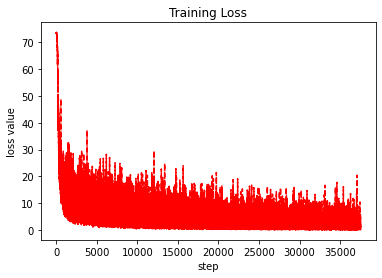

In [9]:
x = [i + 1 for i in range(len(train_loss_list))]
y = train_loss_list
l1 = plt.plot(x, y, 'r--', label='train_loss')

plt.title('Training Loss')
plt.xlabel('step')
plt.ylabel('loss value')
plt.show()

绘制验证损失图

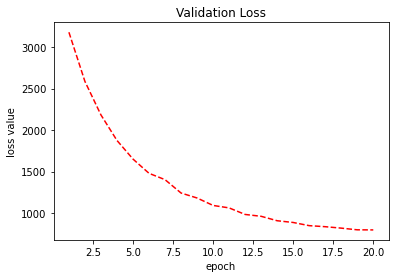

In [10]:
x = [i + 1 for i in range(len(test_loss_list))]
y = test_loss_list
l1 = plt.plot(x, y, 'r--', label='test_loss')

plt.title('Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

绘制验证精度图

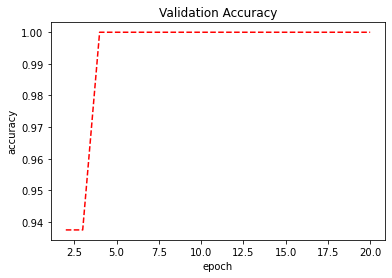

In [11]:
x = [i + 1 for i in range(1, len(test_acc_list))]
y = test_acc_list[1:]
l1 = plt.plot(x, y, 'r--', label='test_acc')

plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

利用torch.nn实现的前馈神经网络模型（解决多分类问题）

In [12]:
# 为进行后续的实验比较，首先固定模型的随机种子
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(20)

在模型初始化时预置隐藏层数量、隐藏层单元数量等超参位置，同时可选择激活函数类型以及dropout率

In [13]:
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

class Feedforward(nn.Module):
    def __init__(self, image_size, class_num, layer_num, hidden_dim, activation, drop_out=0):
        super(Feedforward, self).__init__()

        self.flatten = FlattenLayer()
        self.linear_in = nn.Linear(image_size*image_size, hidden_dim)
        hidden_layers = []
        hidden_layers.append(activation)
        if drop_out > 0:
            hidden_layers.append(nn.Dropout(p=drop_out))
        
        for _ in range(layer_num - 1):
            hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layers.append(activation)
            if drop_out > 0:
                hidden_layers.append(nn.Dropout(p=drop_out))
        self.hidden_layers = nn.Sequential(*hidden_layers)
        self.linear_out = nn.Linear(hidden_dim, class_num)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_in(x)
        x = self.hidden_layers(x)
        x = self.linear_out(x)
        return self.softmax(x)

对比实验系列一: 探究不同激活函数对实验结果的影响

In [14]:
# 超参数设置
epoch_num = 20
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'

layer_num  = 1   # 隐藏层数为1层
hidden_dim = 10 # 隐藏层单元数为10
drop_out   = 0    # 不设置dropout

进行不同激活函数的比较实验

In [16]:
activation = nn.ReLU() #第一种激活函数选用ReLU
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

relu_train_loss_list = []
relu_test_loss_list = []
relu_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        relu_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        relu_test_loss_list.append(total_loss.item())
        relu_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.801257, total_acc: 0.720048
epoch: 2, total loss: 1.655514, total_acc: 0.830771
epoch: 3, total loss: 1.591674, total_acc: 0.896166
epoch: 4, total loss: 1.575018, total_acc: 0.903355
epoch: 5, total loss: 1.566106, total_acc: 0.909645
epoch: 6, total loss: 1.560689, total_acc: 0.913139
epoch: 7, total loss: 1.556305, total_acc: 0.915635
epoch: 8, total loss: 1.553559, total_acc: 0.918031
epoch: 9, total loss: 1.551215, total_acc: 0.919030
epoch: 10, total loss: 1.548974, total_acc: 0.920327
epoch: 11, total loss: 1.547242, total_acc: 0.922624
epoch: 12, total loss: 1.546267, total_acc: 0.921925
epoch: 13, total loss: 1.544906, total_acc: 0.923423
epoch: 14, total loss: 1.544441, total_acc: 0.923522
epoch: 15, total loss: 1.543085, total_acc: 0.924621
epoch: 16, total loss: 1.542415, total_acc: 0.924321
epoch: 17, total loss: 1.541140, total_acc: 0.926917
epoch: 18, total loss: 1.541223, total_acc: 0.926218
epoch: 19, total loss: 1.539435, total_acc: 0.927616
ep

In [18]:
activation = nn.LeakyReLU() #第二种激活函数选用LeakyReLU
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

Lrelu_train_loss_list = []
Lrelu_test_loss_list = []
Lrelu_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        Lrelu_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        Lrelu_test_loss_list.append(total_loss.item())
        Lrelu_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.858088, total_acc: 0.635583
epoch: 2, total loss: 1.693867, total_acc: 0.808007
epoch: 3, total loss: 1.602059, total_acc: 0.890475
epoch: 4, total loss: 1.579557, total_acc: 0.900859
epoch: 5, total loss: 1.568613, total_acc: 0.909545
epoch: 6, total loss: 1.562763, total_acc: 0.912640
epoch: 7, total loss: 1.558452, total_acc: 0.913838
epoch: 8, total loss: 1.555079, total_acc: 0.915236
epoch: 9, total loss: 1.552190, total_acc: 0.917033
epoch: 10, total loss: 1.549334, total_acc: 0.919728
epoch: 11, total loss: 1.547819, total_acc: 0.920527
epoch: 12, total loss: 1.546544, total_acc: 0.921426
epoch: 13, total loss: 1.545835, total_acc: 0.921625
epoch: 14, total loss: 1.543510, total_acc: 0.924022
epoch: 15, total loss: 1.542957, total_acc: 0.925819
epoch: 16, total loss: 1.542954, total_acc: 0.925319
epoch: 17, total loss: 1.541563, total_acc: 0.926018
epoch: 18, total loss: 1.540720, total_acc: 0.925919
epoch: 19, total loss: 1.539642, total_acc: 0.927416
ep

In [21]:
activation = nn.Sigmoid() #第三种激活函数选用Sigmoid
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

sigmoid_train_loss_list = []
sigmoid_test_loss_list = []
sigmoid_test_acc_list = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        sigmoid_train_loss_list.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        sigmoid_test_loss_list.append(total_loss.item())
        sigmoid_test_acc_list.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 2.284889, total_acc: 0.247604
epoch: 2, total loss: 2.212125, total_acc: 0.304712
epoch: 3, total loss: 2.101446, total_acc: 0.385583
epoch: 4, total loss: 2.033496, total_acc: 0.435204
epoch: 5, total loss: 1.966464, total_acc: 0.561302
epoch: 6, total loss: 1.915302, total_acc: 0.610323
epoch: 7, total loss: 1.862468, total_acc: 0.661042
epoch: 8, total loss: 1.837122, total_acc: 0.665635
epoch: 9, total loss: 1.822359, total_acc: 0.668830
epoch: 10, total loss: 1.809166, total_acc: 0.671026
epoch: 11, total loss: 1.783607, total_acc: 0.740415
epoch: 12, total loss: 1.762361, total_acc: 0.751997
epoch: 13, total loss: 1.748724, total_acc: 0.754293
epoch: 14, total loss: 1.739938, total_acc: 0.756789
epoch: 15, total loss: 1.733583, total_acc: 0.757887
epoch: 16, total loss: 1.728917, total_acc: 0.758387
epoch: 17, total loss: 1.725160, total_acc: 0.759784
epoch: 18, total loss: 1.722262, total_acc: 0.760284
epoch: 19, total loss: 1.719587, total_acc: 0.760783
ep

对比使用不同激活函数的实验结果

对比使用不同激活函数的实验结果

 对比使用不同激活函数的实验结果


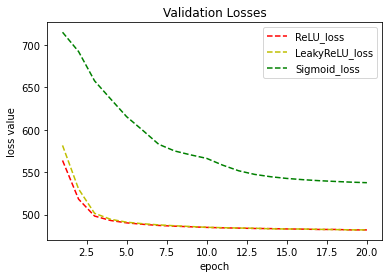

In [24]:
x = [i + 1 for i in range(len(relu_test_loss_list))]
y1 = relu_test_loss_list
y2 = Lrelu_test_loss_list
y3 = sigmoid_test_loss_list
l1 = plt.plot(x, y1, 'r--', label='ReLU_loss')
l2 = plt.plot(x, y2, 'y--', label='LeakyReLU_loss')
l3 = plt.plot(x, y3, 'g--', label='Sigmoid_loss')

plt.title('Validation Losses')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

进行不同隐藏层数的比较实验

In [29]:
# 超参数设置
epoch_num = 20
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'

activation = nn.ReLU()   # 设置激活函数为ReLU
hidden_dim = 10          # 隐藏层单元数为10
drop_out   = 0           # 不设置dropout

In [30]:
layer_num = 1 # 隐藏层层数为1
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

train_loss_list_1 = []
test_loss_list_1 = []
test_acc_list_1 = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        train_loss_list_1.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list_1.append(total_loss.item())
        test_acc_list_1.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.917700, total_acc: 0.570188
epoch: 2, total loss: 1.809146, total_acc: 0.664437
epoch: 3, total loss: 1.675278, total_acc: 0.824081
epoch: 4, total loss: 1.646816, total_acc: 0.832768
epoch: 5, total loss: 1.635011, total_acc: 0.838359
epoch: 6, total loss: 1.629156, total_acc: 0.842252
epoch: 7, total loss: 1.624838, total_acc: 0.844848
epoch: 8, total loss: 1.621275, total_acc: 0.847145
epoch: 9, total loss: 1.618888, total_acc: 0.848143
epoch: 10, total loss: 1.618166, total_acc: 0.849042
epoch: 11, total loss: 1.616780, total_acc: 0.850639
epoch: 12, total loss: 1.614697, total_acc: 0.851538
epoch: 13, total loss: 1.613459, total_acc: 0.854034
epoch: 14, total loss: 1.613234, total_acc: 0.853135
epoch: 15, total loss: 1.612085, total_acc: 0.854333
epoch: 16, total loss: 1.611935, total_acc: 0.854333
epoch: 17, total loss: 1.610619, total_acc: 0.855331
epoch: 18, total loss: 1.610312, total_acc: 0.855331
epoch: 19, total loss: 1.609695, total_acc: 0.856330
ep

In [31]:
layer_num = 3 # 隐藏层层数为3
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

train_loss_list_3 = []
test_loss_list_3 = []
test_acc_list_3 = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        train_loss_list_3.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list_3.append(total_loss.item())
        test_acc_list_3.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 2.215585, total_acc: 0.211062
epoch: 2, total loss: 2.067820, total_acc: 0.391174
epoch: 3, total loss: 1.854879, total_acc: 0.641274
epoch: 4, total loss: 1.682282, total_acc: 0.785443
epoch: 5, total loss: 1.666087, total_acc: 0.799820
epoch: 6, total loss: 1.661743, total_acc: 0.802216
epoch: 7, total loss: 1.649432, total_acc: 0.814996
epoch: 8, total loss: 1.646584, total_acc: 0.816094
epoch: 9, total loss: 1.644416, total_acc: 0.818690
epoch: 10, total loss: 1.640902, total_acc: 0.822883
epoch: 11, total loss: 1.640903, total_acc: 0.820887
epoch: 12, total loss: 1.638732, total_acc: 0.824880
epoch: 13, total loss: 1.640061, total_acc: 0.821685
epoch: 14, total loss: 1.639529, total_acc: 0.821885
epoch: 15, total loss: 1.634453, total_acc: 0.828175
epoch: 16, total loss: 1.634157, total_acc: 0.828474
epoch: 17, total loss: 1.632273, total_acc: 0.829673
epoch: 18, total loss: 1.634289, total_acc: 0.827875
epoch: 19, total loss: 1.630478, total_acc: 0.830571
ep

In [34]:
layer_num = 2 # 隐藏层层数为2
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

train_loss_list_2 = []
test_loss_list_2 = []
test_acc_list_2 = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        train_loss_list_2.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list_2.append(total_loss.item())
        test_acc_list_2.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 2.049699, total_acc: 0.394369
epoch: 2, total loss: 1.787231, total_acc: 0.701378
epoch: 3, total loss: 1.739294, total_acc: 0.730132
epoch: 4, total loss: 1.726341, total_acc: 0.739617
epoch: 5, total loss: 1.721111, total_acc: 0.743510
epoch: 6, total loss: 1.717747, total_acc: 0.744309
epoch: 7, total loss: 1.716201, total_acc: 0.746006
epoch: 8, total loss: 1.714875, total_acc: 0.747204
epoch: 9, total loss: 1.713919, total_acc: 0.746805
epoch: 10, total loss: 1.712556, total_acc: 0.748103
epoch: 11, total loss: 1.712290, total_acc: 0.748802
epoch: 12, total loss: 1.711755, total_acc: 0.749201
epoch: 13, total loss: 1.708680, total_acc: 0.752396
epoch: 14, total loss: 1.708129, total_acc: 0.752496
epoch: 15, total loss: 1.706848, total_acc: 0.754293
epoch: 16, total loss: 1.708649, total_acc: 0.751098
epoch: 17, total loss: 1.705979, total_acc: 0.754692
epoch: 18, total loss: 1.705377, total_acc: 0.754992
epoch: 19, total loss: 1.704863, total_acc: 0.756290
ep

对比使用不同隐藏层数的实验结果

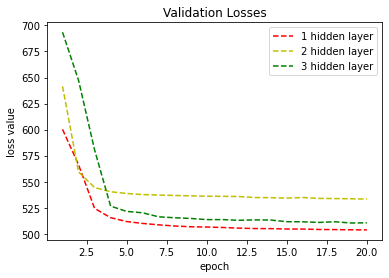

In [36]:
x = [i + 1 for i in range(len(test_loss_list_1))]
y1 = test_loss_list_1
y2 = test_loss_list_2
y3 = test_loss_list_3
l1 = plt.plot(x, y1, 'r--', label='1 hidden layer')
l2 = plt.plot(x, y2, 'y--', label='2 hidden layer')
l3 = plt.plot(x, y3, 'g--', label='3 hidden layer')

plt.title('Validation Losses')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()

进行不同隐藏单元的比较实验

In [37]:
# 超参数设置
epoch_num = 20
lr = 0.03
image_size = 28
class_num = 10
device = 'cuda:0'

activation = nn.ReLU()   # 设置激活函数为ReLU
layer_num  = 1           # 隐藏层单元数为10
drop_out   = 0           # 不设置dropout

In [38]:
hidden_dim = 100 # 隐藏单元数为100
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

train_loss_list_1 = []
test_loss_list_1 = []
test_acc_list_1 = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        train_loss_list_1.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list_1.append(total_loss.item())
        test_acc_list_1.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.756142, total_acc: 0.744209
epoch: 2, total loss: 1.656906, total_acc: 0.835763
epoch: 3, total loss: 1.635599, total_acc: 0.843151
epoch: 4, total loss: 1.626410, total_acc: 0.846745
epoch: 5, total loss: 1.620707, total_acc: 0.850639
epoch: 6, total loss: 1.575456, total_acc: 0.905851
epoch: 7, total loss: 1.560349, total_acc: 0.915236
epoch: 8, total loss: 1.552809, total_acc: 0.920228
epoch: 9, total loss: 1.548078, total_acc: 0.924221
epoch: 10, total loss: 1.544379, total_acc: 0.927017
epoch: 11, total loss: 1.541085, total_acc: 0.929712
epoch: 12, total loss: 1.538207, total_acc: 0.931410
epoch: 13, total loss: 1.535878, total_acc: 0.934605
epoch: 14, total loss: 1.533631, total_acc: 0.935304
epoch: 15, total loss: 1.532212, total_acc: 0.936801
epoch: 16, total loss: 1.530372, total_acc: 0.938199
epoch: 17, total loss: 1.528711, total_acc: 0.938898
epoch: 18, total loss: 1.527313, total_acc: 0.940395
epoch: 19, total loss: 1.526204, total_acc: 0.940895
ep

In [39]:
hidden_dim = 50 # 隐藏单元数为50
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

train_loss_list_5 = []
test_loss_list_5 = []
test_acc_list_5 = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        train_loss_list_5.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list_5.append(total_loss.item())
        test_acc_list_5.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.727297, total_acc: 0.810903
epoch: 2, total loss: 1.648846, total_acc: 0.836362
epoch: 3, total loss: 1.632384, total_acc: 0.843051
epoch: 4, total loss: 1.625154, total_acc: 0.847943
epoch: 5, total loss: 1.621002, total_acc: 0.849940
epoch: 6, total loss: 1.614650, total_acc: 0.855431
epoch: 7, total loss: 1.565315, total_acc: 0.912540
epoch: 8, total loss: 1.554814, total_acc: 0.918830
epoch: 9, total loss: 1.550416, total_acc: 0.921226
epoch: 10, total loss: 1.545472, total_acc: 0.925220
epoch: 11, total loss: 1.543026, total_acc: 0.926617
epoch: 12, total loss: 1.540861, total_acc: 0.928215
epoch: 13, total loss: 1.537733, total_acc: 0.932208
epoch: 14, total loss: 1.536160, total_acc: 0.932109
epoch: 15, total loss: 1.534725, total_acc: 0.934205
epoch: 16, total loss: 1.532552, total_acc: 0.935703
epoch: 17, total loss: 1.531015, total_acc: 0.937001
epoch: 18, total loss: 1.530003, total_acc: 0.937500
epoch: 19, total loss: 1.528943, total_acc: 0.939097
ep

In [41]:
hidden_dim = 10 # 隐藏单元数为10
net = Feedforward(image_size=image_size, class_num=class_num, layer_num=layer_num, hidden_dim=hidden_dim, activation=activation, drop_out=drop_out).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.03)
loss = nn.CrossEntropyLoss()

train_loss_list_10 = []
test_loss_list_10 = []
test_acc_list_10 = []
for epoch in range(epoch_num):
    for i, datas in enumerate(train_loader):
        train_x, train_label = datas[0].to(device), datas[1].to(device)
        train_pred = net.forward(train_x)
        l = loss(train_pred, train_label).sum()
        opt.zero_grad()
        l.backward()
        opt.step()
        train_loss_list_10.append(l.item())
    
    with torch.no_grad():
        total_loss = 0
        total_acc = 0
        for i, datas in enumerate(test_loader):
            test_x, test_label = datas[0].to(device), datas[1].to(device)
            test_pred = net.forward(test_x)

            l = loss(test_pred, test_label).sum()
            total_loss += l

            acc = accuracy(test_pred, test_label) / len(test_pred)
            total_acc += acc

        test_loss_list_10.append(total_loss.item())
        test_acc_list_10.append(acc)
        print('epoch: %d, total loss: %f, total_acc: %f'%(epoch + 1, total_loss / (i+1), total_acc / (i+1)))

/tmp/ipykernel_3590706/185350952.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(x)


epoch: 1, total loss: 1.808147, total_acc: 0.716554
epoch: 2, total loss: 1.729048, total_acc: 0.749900
epoch: 3, total loss: 1.715253, total_acc: 0.755192
epoch: 4, total loss: 1.709689, total_acc: 0.758686
epoch: 5, total loss: 1.669959, total_acc: 0.810903
epoch: 6, total loss: 1.650052, total_acc: 0.823782
epoch: 7, total loss: 1.642400, total_acc: 0.828175
epoch: 8, total loss: 1.637551, total_acc: 0.831769
epoch: 9, total loss: 1.634582, total_acc: 0.834465
epoch: 10, total loss: 1.632177, total_acc: 0.835363
epoch: 11, total loss: 1.630101, total_acc: 0.837061
epoch: 12, total loss: 1.629202, total_acc: 0.837560
epoch: 13, total loss: 1.627949, total_acc: 0.837260
epoch: 14, total loss: 1.627021, total_acc: 0.839157
epoch: 15, total loss: 1.626191, total_acc: 0.838458
epoch: 16, total loss: 1.625905, total_acc: 0.839157
epoch: 17, total loss: 1.624621, total_acc: 0.840056
epoch: 18, total loss: 1.624572, total_acc: 0.840256
epoch: 19, total loss: 1.623733, total_acc: 0.839856
ep

对比使用不同隐藏单元数的实验结果

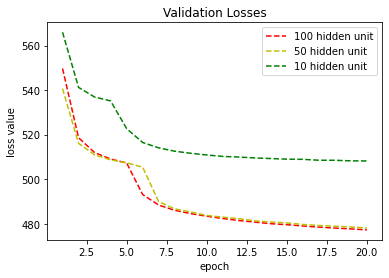

In [42]:
x = [i + 1 for i in range(len(test_loss_list_1))]
y1 = test_loss_list_1
y2 = test_loss_list_5
y3 = test_loss_list_10
l1 = plt.plot(x, y1, 'r--', label='100 hidden unit')
l2 = plt.plot(x, y2, 'y--', label='50 hidden unit')
l3 = plt.plot(x, y3, 'g--', label='10 hidden unit')

plt.title('Validation Losses')
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.legend()
plt.show()